# 01 - Introduction to NLP in `fastai2`

Things work a little differently in `fastai2` for text compared to the other two modules (vision and tab)


* We pre-tokenize our text
* The training outline is different
* ULM-FiT get's fine-tuned differently too

In today's lesson we'll explore the *high-level* API for Text, and understand what makes it different

In [ ]:
!pip install fastai2 nbdev --quiet
!pip show fastai2

## Starting with the data

In [ ]:
from fastai2.text.all import *

We're going to use a subset of the IMDB dataset, a sentiment-analysis dataset where you try to see if a review was positive or negative:

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

What's in our path?

In [ ]:
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

In [ ]:
df = pd.read_csv(path/'texts.csv')

In [ ]:
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


Alright! So what's the general plan for training?

1. Language Model (LM) DataLoaders
2. LM Training
3. Classification DataLoaders
4. Fine-Tune with LM encoder

We're just going to touch on how to use the API, in the next lesson we'll touch on the nitty-gritty of what is going on. For now, let's look at how to build this LM DataLoader using the `DataBlock` API:

### `TextBlock`

As it's a text problem, we'll probably want something like a `TextBlock` right? Well we can't simply do this:

In [ ]:
block = [TextBlock]

It won't throw any errors yet, so *why*?

In [ ]:
doc(TextBlock)

`TextBlock` needs to know how we plan to tokenize our words (our `tok_tfm`), if we want to use a vocab already, if it's a language model, our sequence length, and a few other parameters. So there's a lot going on there!

Along with this there's a few class methods for this too:

In [ ]:
doc(TextBlock.from_df)

In [ ]:
doc(TextBlock.from_folder)

So we can see if we don't necissarily want to define everything ourself we can use quick and easy `from_df` and `from_folder` methods. We'll use `from_df` here. 

But what? What is this `res_col_name`? `res_col_name` is the column where our tokenized text will be added to. This becomes *very* important as our `get_x` is going to want to pull from this column rather than where our untokenized input is. So let's build a `TextBlock` for our problem. So we can see a different output, we'll change our `res_col_name` to `tok_text`:

In [ ]:
lm_block = TextBlock.from_df('text', is_lm=True, res_col_name='tok_text')

For the rest of our `DataBlock`, we want our `get_x` to read that `res_col_name` column, and our splitter to split our data 90%, 10%: 

> The more data you can train your LM on, the better:

In [ ]:
dblock = DataBlock(blocks=lm_block,
                   get_x=ColReader('tok_text'),
                   splitter=RandomSplitter(0.1))

And now we build the `DataLoaders`. We need to declare how long our sequence length is going to be here as well:

> We'll also set `num_workers` to 4, the rule of thumb is 4 workers / 1 GPU, [source](https://discuss.pytorch.org/t/guidelines-for-assigning-num-workers-to-dataloader/813/5)

In [ ]:
%%time
dls = dblock.dataloaders(df, bs=64, seq_len=72, num_workers=4)

CPU times: user 766 ms, sys: 79.2 ms, total: 845 ms
Wall time: 3.47 s


Let's look at a batch of data, both in a raw form and as a show_batch:

In [ ]:
dls.show_batch(max_n=3)

,text,text_
0,"xxbos i xxunk this movie a xxunk days xxunk … what the xxunk was that ? \n\n i like movies with xxmaj xxunk xxunk , they are xxunk and xxunk . xxmaj when i xxunk a xxunk of this xxunk and xxunk i xxunk great , this one could be really good … some xxunk for xxunk or xxunk xxunk movies … but xxunk then i xxunk a xxunk and xxunk xxunk","i xxunk this movie a xxunk days xxunk … what the xxunk was that ? \n\n i like movies with xxmaj xxunk xxunk , they are xxunk and xxunk . xxmaj when i xxunk a xxunk of this xxunk and xxunk i xxunk great , this one could be really good … some xxunk for xxunk or xxunk xxunk movies … but xxunk then i xxunk a xxunk and xxunk xxunk it"
1,"xxunk . xxmaj the xxunk is , i xxunk n't xxunk this film at all xxunk . \n\n xxmaj it 's the xxunk of xxunk you xxunk xxunk to see xxunk on a xxunk as a xxunk xxunk xxunk and as an xxunk in xxunk xxunk xxunk , xxunk xxunk . and just xxunk the xxunk , it xxunk on some xxunk . xxmaj as a xxunk xxunk of film though ,",". xxmaj the xxunk is , i xxunk n't xxunk this film at all xxunk . \n\n xxmaj it 's the xxunk of xxunk you xxunk xxunk to see xxunk on a xxunk as a xxunk xxunk xxunk and as an xxunk in xxunk xxunk xxunk , xxunk xxunk . and just xxunk the xxunk , it xxunk on some xxunk . xxmaj as a xxunk xxunk of film though , it"
2,"were xxunk xxunk on such a xxunk of a movie … if you can even xxunk it a movie . xxbos xxmaj the only xxunk xxunk of this film is the xxunk xxunk … xxunk , this movie was xxunk . xxmaj the acting was xxunk xxunk , and the xxunk xxunk was xxunk and very xxunk . xxmaj the xxunk was xxunk , but it was very hard to xxunk xxunk","xxunk xxunk on such a xxunk of a movie … if you can even xxunk it a movie . xxbos xxmaj the only xxunk xxunk of this film is the xxunk xxunk … xxunk , this movie was xxunk . xxmaj the acting was xxunk xxunk , and the xxunk xxunk was xxunk and very xxunk . xxmaj the xxunk was xxunk , but it was very hard to xxunk xxunk to"


So this looks a bit odd, what happened?

* Tokenized and Numericalized our text (we'll see the latter in a moment)
* LM's want to predict the *next* word in a sequence

In [ ]:
xb,yb = next(iter(dls[0]))

In [ ]:
xb[0]

tensor([  2,  25,   0,   0,   8,   0,  38,   0,   0,  86,  16,   0,  66,  11,
         12,  27,   0,  86,  25,   0,   9,   0,  21,  18,  26,  11,  12, 102,
         73,  48,  86,  25,   0,  19,   8,   0,  92,   0,  16,   0,  10,   8,
          9,  26,  11,   0,  11,  27,  14,   0,   0,  10,   8,   9,   0,  28,
          0,   0,   9,   0,  12,   0,   0,  13,   9,   0,   0,  11,  12,   9,
          0,  17], device='cuda:0')

In [ ]:
yb[0]

tensor([ 25,   0,   0,   8,   0,  38,   0,   0,  86,  16,   0,  66,  11,  12,
         27,   0,  86,  25,   0,   9,   0,  21,  18,  26,  11,  12, 102,  73,
         48,  86,  25,   0,  19,   8,   0,  92,   0,  16,   0,  10,   8,   9,
         26,  11,   0,  11,  27,  14,   0,   0,  10,   8,   9,   0,  28,   0,
          0,   9,   0,  12,   0,   0,  13,   9,   0,   0,  11,  12,   9,   0,
         17,   0], device='cuda:0')

This is where that `Numericalization` comes into play. Each token/vocabulary gets converted into a number for us to pass to our model, also:

In [ ]:
xb[0].shape, yb[0].shape

(torch.Size([72]), torch.Size([72]))

We can see that since we passed in a `seq_len` of 72, each individual text input is 72 words!

Cool, can we train already?

## Training the LM:


We have a special `Learner` for language models, `language_model_learner` we'll use. The only thing you need to pass in is your `DataLoaders`, specify the `arch`, and pass in some metrics:

In [ ]:
doc(language_model_learner)

Potentially, if you have your own pre-trained base model you want to use you can pass in a `pretrained_fname`, otherwise we'll use a pretrained `WikiText103` model.

For our metrics we'll be using both accuracy and `Perplexity`

What is Perplexity? Teaching our model how to deal with uncertainty in language.

> Perplexity metric in NLP is a way to capture the degree of 'uncertainty' a model has in predicting (assigning probabilities to) some text. Lower the entropy (uncertainty), lower the perplexity. If a model, which is trained on good blogs and is being evaluated on similarly looking good blogs, assigns higher probability, we say the model has lower perplexity than a model which assigns lower probability. [source](https://www.quora.com/What-is-perplexity-in-NLP)

In [ ]:
doc(Perplexity)

So now let's build our `Learner`. For an arch we'll use the `AWD_LSTM` (we'll explore more later on) pretrained on `WikiText`:

In [ ]:
learn = language_model_learner(dls, AWD_LSTM, metrics=[accuracy, Perplexity()])

For training our model, we'll simply use `fine_tune` for a few epochs (mostly due to the small sample size):

In [ ]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.058100,2.642663,0.390180,14.050574,00:10


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.833319,2.535338,0.411559,12.620695,00:12
1,2.716148,2.460023,0.418889,11.705077,00:12
2,2.635717,2.426812,0.421273,11.322727,00:12
3,2.590852,2.411244,0.423066,11.147822,00:12
4,2.569319,2.407586,0.423487,11.107115,00:12


That's about what we want in accuracy, ~30-40%, don't expect higher unless you *know* the model can. Remember: we're predicting the next word given the previous few, a hard task! Now that we have our LM, we want to save those embeddings away.

Embeddings?

In [ ]:
learn.model[0].encoder

Embedding(184, 400, padding_idx=1)

These embeddings! This is essentially our ImageNet weights. Along with this, for the downstream task we'll also want our vocab, so we'll actually go ahead and save our `DataLoaders` too.

How do we do this? Using `torch.save` and `save_encoder`:

In [ ]:
torch.save(learn.dls, 'lm_dls.pth')

In [ ]:
learn.save_encoder('fine_tuned_enc')

Our model has been saved to the `models` directory now. Let's work on our downstream task:

## Classification

Now classification is what we actually want to do: is this review `pos` or `neg`

Let's look at our `DataFrame` one more time to figure out how to frame our `DataBlock`:

In [ ]:
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


So we'll want another `ColReader` to grab our label and to split our data by the `is_valid` column. First let's get everything ready by loading in those `DataLoaders` from earlier:

In [ ]:
lm_dls = torch.load('lm_dls.pth')

We need these because we already have a vocab to use, and a sequence length:

In [ ]:
blocks = (TextBlock.from_df('text', res_col_name='tok_text', seq_len=lm_dls.seq_len,
                            vocab=lm_dls.vocab), CategoryBlock())

Then we'll build our `DataBlock`:

In [ ]:
imdb_class = DataBlock(blocks=blocks,
                       get_x=ColReader('tok_text'),
                       get_y=ColReader('label'),
                       splitter=ColSplitter(col='is_valid'))

And finally the `DataLoaders`:

In [ ]:
dls = imdb_class.dataloaders(df, bs=64)

Those with a keen eye will notice how we called `.vocab`, but before that meant how we grab our classes! So how do we do this here?

Since `Categorize` (what `CategoryBlock` adds) is a transform that's stored as an attribute, we can grab our classes that way:

In [ ]:
dls.categorize.vocab

(#2) ['negative','positive']

## `text_classifier_learner`

Next up is the `text_classifier_learner`. This is what we'll use to make our classification AWD_LSTM:

In [ ]:
doc(text_classifier_learner)

In [ ]:
learn = text_classifier_learner(dls, AWD_LSTM, metrics=[accuracy])

Now we have our pretrained embeddings right? Let's look at it in our `learn`:

In [ ]:
learn.model[0].module.encoder

Embedding(184, 400, padding_idx=1)

It's right there! So we have a `load_encoder` function that will copy over our weights to there:

In [ ]:
doc(learn.load_encoder)

In [ ]:
learn.load_encoder('fine_tuned_enc');

> Note: It will automatically assume that your model is saved in `learn.path` in the `models` folder and has the extention `.pth`

So now we have our frozen model and our pretrained weights. Let's train!

We're going to use a training methodology that Jeremy and Sebastian Ruder came up with for fine-tuning:

1. Find a learning rate
2. Lower that learning rate each time, slowly unfreezing fitting for 1 epoch at a time
3. Finally unfreeze the model and fit for two epochs:

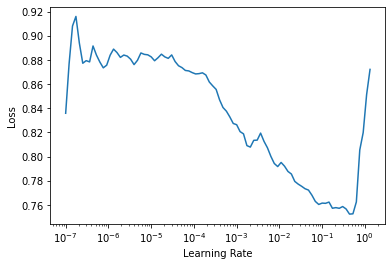

In [ ]:
lr = learn.lr_find(suggestions=True)

In [ ]:
lr

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0014454397605732083)

That's about 4e-2, so I'll agree with it, let's train on this schema:

In [ ]:
lr = 0.04365158379077912

First one epoch completely frozen:

In [ ]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.725329,0.660920,0.610000,00:03


Then we freeze to `-2` and adjust our `lr`:

In [ ]:
doc(learn.freeze_to)

In [ ]:
adj = 2.6**4; adj

45.69760000000001

This adjuster schema is how we will divide our `lr` during fitting (we'll also adjust our learning rate outside of it):

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(lr/adj, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.728662,0.663544,0.595000,00:05


Then -3:

In [ ]:
learn.freeze_to(-3)
lr /= 2
learn.fit_one_cycle(1, slice(lr/adj, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.631015,0.583745,0.680000,00:05


In [ ]:
learn.unfreeze()
lr /= 5
learn.fit_one_cycle(2, slice(lr/adj, lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.492473,0.531331,0.725000,00:08
1,0.448703,0.533241,0.735000,00:08


73.5% is as high as we got given a subset of only 1,000 texts! Not to shabby, with the full version we can expect around 94.5% accuracy (this was their results in the paper). 

Now let's show an example predict, and for fun, compare `fastai2` to `fastinference`

> **Warning**: the `ULMFiT` model will *not* export to ONNX

In [ ]:
%%time
out = learn.predict(df.iloc[0]['text'])

CPU times: user 39.6 ms, sys: 2.15 ms, total: 41.7 ms
Wall time: 46.4 ms


In [ ]:
out

('negative', tensor(0), tensor([0.6171, 0.3829]))

In [ ]:
dl = learn.dls.test_dl(df.iloc[:1]['text'])

In [ ]:
%%time
preds = learn.get_preds(dl=dl)

CPU times: user 33.9 ms, sys: 52.5 ms, total: 86.4 ms
Wall time: 127 ms


In [ ]:
preds

(tensor([[0.6171, 0.3829]]), None)

What about `fastinference`?

In [ ]:
!pip install fastinference --quiet

In [ ]:
from fastinference.inference import *

In [ ]:
%%time
out = learn.predict(df.iloc[0]['text'])

CPU times: user 22.9 ms, sys: 4.6 ms, total: 27.5 ms
Wall time: 33.7 ms


In [ ]:
out

[['negative'], array([[0.6171321, 0.3828678]], dtype=float32)]

In [ ]:
%%time
preds = learn.get_preds(dl=dl)

CPU times: user 20.3 ms, sys: 52.6 ms, total: 72.9 ms
Wall time: 105 ms


We can still shave off some time!

In [ ]:
preds

[['negative'], array([[0.6171321, 0.3828678]], dtype=float32)]

While also still getting our classes back each time too